# Loading the data and the packages / libraries


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_v1_id = '1QzIm1OrQYhbwY7dRtdkGLK2kFOwoSfgR'

test_a_id = '17sLsGw5e2WyLWnGRqHWfbIM8fVoJPcdW'

test_b_id = '11KtpkmEZMQj-PmtfyHLlxU3Ue9UbTJmp'

test_c_id = '1_nizVEge67DbGrEv_cppl14FxU90CU1r'


downloaded_train = drive.CreateFile({'id':train_v1_id}) 
downloaded_train.GetContentFile('offenseval-training-v1.tsv') 

downloaded_test_a = drive.CreateFile({'id':test_a_id}) 
downloaded_test_a.GetContentFile('testset-taska.tsv')

downloaded_test_b = drive.CreateFile({'id':test_b_id}) 
downloaded_test_b.GetContentFile('testset-taskb.tsv') 

downloaded_test_c = drive.CreateFile({'id':test_c_id}) 
downloaded_test_c.GetContentFile('test_set_taskc.tsv') 






    100% |████████████████████████████████| 993kB 20.8MB/s 


In [0]:

# Import
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import spacy
import re
import os

import logging
from gensim.models import FastText
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.models import Model
from keras import Sequential
from keras.layers import Dropout, Conv1D, MaxPooling1D, LSTM,Concatenate, Dense, GlobalMaxPooling1D,GlobalAveragePooling1D, Lambda, Input, Bidirectional, GRU, concatenate, SpatialDropout1D, Reshape, merge
from keras.layers.embeddings import Embedding


import GPyOpt

In [0]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

# Dataset details

In [0]:
# Load the unlabelled dataset

test_data_a = pd.read_csv("testset-taska.tsv", sep = "\t", header = 0)
test_data_b = pd.read_csv("testset-taskb.tsv", sep = "\t", header = 0)
test_data_c = pd.read_csv("test_set_taskc.tsv", sep = "\t", header = 0)

In [0]:
# Load the labelled dataset

data = pd.read_csv("offenseval-training-v1.tsv", sep = "\t", header = 0)

In [0]:
print("Dataset size:", len(data))

Dataset size: 13240


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [0]:
data.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


# Preprocessing 

## Dataset base-cleaning

In [0]:
# Load stopwords from SpaCy

nlp = spacy.load("en")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [0]:
# Text preprocessing 
def clean_data(tweet):
    splitted_tweet = tweet.lower().split()
    clean_tweet = []
    previous_word = None
    user_count = 0
    for word in splitted_tweet:
        #if word not in spacy_stopwords:
        word = re.sub("[#@]","",word)
        word = re.sub("!"," !",word)
        word = re.sub("[?]"," ?",word)
        
        if(word == "user"):
          user_count += 1
          
        if(word == "user" and previous_word == "user"):
          pass
        else:
          clean_tweet.append(word)
          
        previous_word = word
          
    return " ".join(clean_tweet), user_count

In [0]:
#clean data and count users
data = data.merge(data.tweet.apply(lambda x:pd.Series({'clean':clean_data(x)[0], 'user_count': clean_data(x)[1]})), left_index=True, right_index=True)

In [0]:
# Normalise the user count in order to have better training performance in the neural network
max_ = data["user_count"].max()
data["user_count"] = data["user_count"].apply(lambda x:x/max_);

In [0]:
data_a = data[data["subtask_a"].notna()]
data_b = data[data["subtask_b"].notna()]
data_c = data[data["subtask_c"].notna()]

In [0]:
X_a = data_a[["clean", "user_count"]]
label_a = data_a["subtask_a"]
X_b = data_b[["clean", "user_count"]]
label_b = data_b["subtask_b"]
X_c = data_c[["clean", "user_count"]]
label_c = data_c["subtask_c"]

In [0]:
label_to_number_a = {'OFF':0,'NOT':1}
label_to_number_b = {'UNT':0,'TIN':1}
label_to_number_c = {'IND':0,'OTH':1,'GRP':2}
number_to_label_a = {v:k for k, v in label_to_number_a.items()}
number_to_label_b = {v:k for k, v in label_to_number_b.items()}
number_to_label_c = {v:k for k, v in label_to_number_c.items()}
binary_labels_a = data_a.subtask_a.apply(lambda x:label_to_number_a[x])
binary_labels_b = data_b.subtask_b.apply(lambda x:label_to_number_b[x])
binary_labels_c = data_c.subtask_c.apply(lambda x:label_to_number_c[x])

In [0]:

# Tokenisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.clean)
sequences = tokenizer.texts_to_sequences(data.clean)
seq = pad_sequences(sequences)

max_seq = len(seq[0])
print("maximum length of a sequence:" ,max_seq)

# Text to token
def build_seq(dataset):
  sequences = tokenizer.texts_to_sequences(dataset.clean)
  seq = pad_sequences(sequences, maxlen=max_seq)
  return seq


maximum length of a sequence: 63


In [0]:
X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=0.2)
X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=0.2)
X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=0.2)

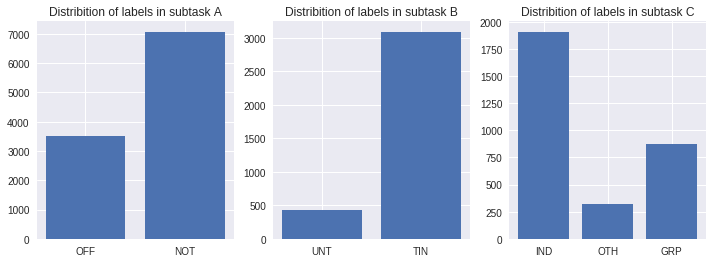

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(131)
cat_a = Counter(y_train_a)
plt.bar(list(cat_a.keys()), list(cat_a.values()))
plt.xticks(range(len(cat_a)), label_to_number_a)
plt.title("Distribition of labels in subtask A");
plt.subplot(132)
cat_b = Counter(y_train_b)
plt.bar(list(cat_b.keys()), list(cat_b.values()))
plt.xticks(range(len(cat_b)), label_to_number_b)
plt.title("Distribition of labels in subtask B");
plt.subplot(133)
cat_c = Counter(y_train_c)
plt.bar(list(cat_c.keys()), list(cat_c.values()))
plt.xticks(range(len(cat_c)), label_to_number_c)
plt.title("Distribition of labels in subtask C");

## Over / under -spampling

The dataset is highly imbalanced, so we decide to combine oversampling and undersampling in order to have balanced dataset

In [0]:
def same_size_data(X_train, count_train, y_train, ratio_down_over_up=0.5):
  X_train = list(X_train)
  count_train = list(count_train)
  y_train = list(y_train)
  
  n_cat = len(Counter(y_train))
  
  sorted_counter = Counter(y_train).most_common()
  max_cat = sorted_counter[0][1]
  min_cat = sorted_counter[-1][1]
  
  target = min_cat + (1-ratio_down_over_up)*(max_cat - min_cat)
  
  for i in range(n_cat):
    diff = int(sorted_counter[i][1] - target)
    k = 0
    if diff > 0:
      rm = 0    
      while rm <= diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.pop(k)
          y_train.pop(k)
          count_train.pop(k)
          rm += 1
          k -=1
        k += 1
    else:
      ad = 0
      while ad <= -diff:
        if(y_train[k] == sorted_counter[i][0]):
          X_train.append(X_train[k])
          y_train.append(y_train[k])
          count_train.append(count_train[k])
          ad += 1
        k += 1
        
  return X_train, count_train, y_train

In [0]:
X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, 0.3)
X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, 0.2)
X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, 0.7)
X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)

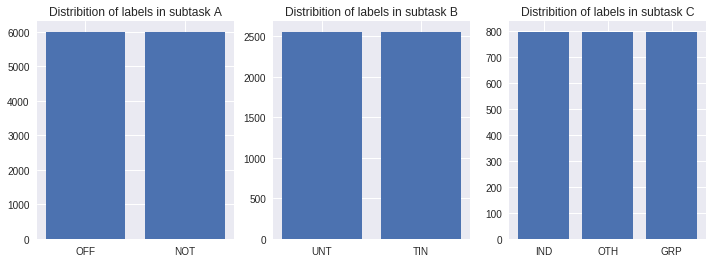

In [0]:
plt.figure(figsize = (12,4))
plt.subplot(131)
cat_a = Counter(y_train_a)
plt.bar(list(cat_a.keys()), list(cat_a.values()))
plt.xticks(range(len(cat_a)), label_to_number_a)
plt.title("Distribition of labels in subtask A");
plt.subplot(132)
cat_b = Counter(y_train_b)
plt.bar(list(cat_b.keys()), list(cat_b.values()))
plt.xticks(range(len(cat_b)), label_to_number_b)
plt.title("Distribition of labels in subtask B");
plt.subplot(133)
cat_c = Counter(y_train_c)
plt.bar(list(cat_c.keys()), list(cat_c.values()))
plt.xticks(range(len(cat_c)), label_to_number_c)
plt.title("Distribition of labels in subtask C");

# Baseline: Bag-of-Words model

In order to determine the ration of undersampling and oversampling, we use a Random Forest Classier in different ratio and perform a cross-validation.

In [0]:
def bag_of_words_class_tune_sampling(tweets_train, counts_train, label_train, tweets_test, count_test, label_test):
  tweets_train = tokenizer.sequences_to_texts(tweets_train)
  tweets_test = tokenizer.sequences_to_texts(tweets_test)
  v = CountVectorizer()
  transformed_train = v.fit_transform(tweets_train)
  transformed_test = v.transform(tweets_test)
  rf = RandomForestClassifier()
  rf.fit(scipy.sparse.hstack([transformed_train,  scipy.sparse.coo_matrix(np.array(counts_train)[:, None])]), label_train)
  
  sum = 0
  for key, elem in classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test, output_dict = True).items():
    sum += classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test, output_dict = True)[key]["f1-score"]
    
  return sum

In [0]:
a_score = 0
b_score = 0
c_score = 0

best_a_ratio = 0.1
best_b_ratio = 0.1
best_c_ratio = 0.1

for i in range(9):
  
  print("iter {}".format(i))
  temp_ratio = 0.1+i*0.1
  
  X_train_a, X_test_a, count_train_a, count_test_a, y_train_a, y_test_a = train_test_split(build_seq(X_a), X_a.user_count, binary_labels_a, test_size=0.2)
  X_train_b, X_test_b, count_train_b, count_test_b, y_train_b, y_test_b = train_test_split(build_seq(X_b), X_b.user_count, binary_labels_b, test_size=0.2)
  X_train_c, X_test_c, count_train_c, count_test_c, y_train_c, y_test_c = train_test_split(build_seq(X_c), X_c.user_count, binary_labels_c, test_size=0.2)
  
  X_train_a, count_train_a, y_train_a = same_size_data(X_train_a, count_train_a, y_train_a, temp_ratio)
  X_train_a, count_train_a, y_train_a = shuffle(X_train_a, count_train_a, y_train_a)
  X_train_b, count_train_b, y_train_b = same_size_data(X_train_b, count_train_b, y_train_b, temp_ratio)
  X_train_b, count_train_b, y_train_b = shuffle(X_train_b, count_train_b, y_train_b)
  X_train_c, count_train_c, y_train_c = same_size_data(X_train_c, count_train_c, y_train_c, temp_ratio)
  X_train_c, count_train_c, y_train_c = shuffle(X_train_c, count_train_c, y_train_c)
  
  temp_a = bag_of_words_class_tune_sampling(X_train_a, count_train_a ,y_train_a, X_test_a, count_test_a ,y_test_a)
  temp_b = bag_of_words_class_tune_sampling(X_train_b,count_train_b ,y_train_b, X_test_b,count_test_b ,y_test_b)
  temp_c = bag_of_words_class_tune_sampling(X_train_c,count_train_c ,y_train_c, X_test_c,count_test_c ,y_test_c)
  
  if(temp_a > a_score):
    best_a_ratio = temp_ratio
    a_score = temp_a
  if(temp_b > b_score):
    best_b_ratio = temp_ratio
    b_score = temp_b
  if(temp_c > c_score):
    best_c_ratio = temp_ratio
    c_score = temp_c
    
print("best_a_ratio = {}".format(best_a_ratio))
print("best_b_ratio = {}".format(best_b_ratio))
print("best_c_ratio = {}".format(best_c_ratio))

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
best_a_ratio = 0.30000000000000004
best_b_ratio = 0.1
best_c_ratio = 0.4


In [0]:
def bag_of_words_test(tweets_train, counts_train, label_train, tweets_test, count_test, label_test):
  tweets_train = tokenizer.sequences_to_texts(tweets_train)
  tweets_test = tokenizer.sequences_to_texts(tweets_test)
  v = CountVectorizer()
  transformed_train = v.fit_transform(tweets_train)
  transformed_test = v.transform(tweets_test)
  rf = RandomForestClassifier()
  rf.fit(scipy.sparse.hstack([transformed_train,  scipy.sparse.coo_matrix(np.array(counts_train)[:, None])]), label_train)
  print(classification_report(rf.predict(scipy.sparse.hstack([transformed_test,  scipy.sparse.coo_matrix(np.array(count_test)[:, None])])), label_test))

In [0]:
### Baseline results
bag_of_words_test(X_train_a, count_train_a ,y_train_a, X_test_a, count_test_a ,y_test_a)
bag_of_words_test(X_train_b,count_train_b ,y_train_b, X_test_b,count_test_b ,y_test_b)
bag_of_words_test(X_train_c,count_train_c ,y_train_c, X_test_c,count_test_c ,y_test_c)

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       887
           1       0.79      0.79      0.79      1761

   micro avg       0.72      0.72      0.72      2648
   macro avg       0.68      0.68      0.68      2648
weighted avg       0.72      0.72      0.72      2648

              precision    recall  f1-score   support

           0       0.37      0.30      0.33       114
           1       0.90      0.92      0.91       766

   micro avg       0.84      0.84      0.84       880
   macro avg       0.63      0.61      0.62       880
weighted avg       0.83      0.84      0.84       880

              precision    recall  f1-score   support

           0       0.75      0.76      0.76       487
           1       0.13      0.14      0.14        71
           2       0.48      0.44      0.46       218

   micro avg       0.62      0.62      0.62       776
   macro avg       0.45      0.45      0.45       776
weighted avg       0

# Train our own embeddings

In [0]:
EMBEDDING_SIZE = 100

In [0]:
sequences = tokenizer.texts_to_sequences(data.clean)
seq = pad_sequences(sequences)
preprocessed = tokenizer.sequences_to_texts(seq))
sentences = [t.split() for t in preprocessed]

In [0]:
model = FastText(sentences, size=EMBEDDING_SIZE, window=5, min_count=1, workers=4, iter = 40)

### Embedding matrix

In [0]:
# Code if you want to use the GloVe Embedding 
embeddings_index = {}
f = open(os.path.join('glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [0]:
vocabulary_size = len(tokenizer.word_index)
vocabulary_size

21250

In [0]:
# Construct the embedding matrix for 
embedding_matrix = np.zeros((vocabulary_size+1, EMBEDDING_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model.wv.word_vec(word) 
        #embedding_vector = embeddings_index[word] uncomment if you want to use GloVe
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        print(word)

# Convolutional Neural Network

In [0]:
# Define the layers

inp = Input(shape = (max_seq,))


y = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], input_length=max_seq, trainable = True)(inp)
y = Dropout(0.5)(y)
y = Conv1D(64, 4, activation='relu')(y)
y = GlobalMaxPooling1D()(y)
y = Dense(10, activation = 'relu')(y)

# The output depends on the task so we define one for a binary classification and one for prediction 3 classes
ab = Dense(1, activation = 'sigmoid')(y)
c = Dense(3, activation = 'sigmoid')(y)


Task A

In [0]:
model_conv_a = Model(inputs = inp, outputs = ab)
model_conv_a.compile(loss = "binary_crossentropy", optimizer='adam', metrics=["accuracy"] )
model_conv_a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 63)                0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 63, 100)           2125100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 100)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 60, 64)            25664     
_________________________________________________________________
global_max_pooling1d_31 (Glo (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 11        
Total para

In [0]:
model_conv_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 10)

Train on 7791 samples, validate on 2648 samples
Epoch 1/10
7791/7791 [==============================] - 33s 4ms/step - loss: 1.0340 - acc: 0.5197 - val_loss: 0.6737 - val_acc: 0.5823
Epoch 2/10
7791/7791 [==============================] - 11s 1ms/step - loss: 0.7044 - acc: 0.5517 - val_loss: 0.6458 - val_acc: 0.6594
Epoch 3/10
7791/7791 [==============================] - 11s 1ms/step - loss: 0.6824 - acc: 0.5723 - val_loss: 0.6513 - val_acc: 0.6477
Epoch 4/10
7791/7791 [==============================] - 12s 1ms/step - loss: 0.6689 - acc: 0.5963 - val_loss: 0.6258 - val_acc: 0.6711
Epoch 5/10
7791/7791 [==============================] - 12s 1ms/step - loss: 0.6603 - acc: 0.6042 - val_loss: 0.6271 - val_acc: 0.6794
Epoch 6/10
7791/7791 [==============================] - 11s 1ms/step - loss: 0.6480 - acc: 0.6196 - val_loss: 0.6072 - val_acc: 0.6945
Epoch 7/10
7791/7791 [==============================] - 11s 1ms/step - loss: 0.6398 - acc: 0.6307 - val_loss: 0.6010 - val_acc: 0.7013
Epoch 8

In [0]:
y_pred_a = model_conv_a.predict(X_test_a)
y_pred_a = y_pred_a>0.5
print(classification_report(y_test_a, y_pred_a, target_names= ["OFF",'NOT']))

              precision    recall  f1-score   support

         OFF       0.56      0.50      0.53       855
         NOT       0.77      0.81      0.79      1793

   micro avg       0.71      0.71      0.71      2648
   macro avg       0.66      0.65      0.66      2648
weighted avg       0.70      0.71      0.71      2648



Task B

In [0]:
model_conv_b = Model(inputs = inp, outputs = ab)
model_conv_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"] )
model_conv_b.fit(np.array(X_train_b), y_train_b, validation_data=(X_test_b,y_test_b), epochs = 10)

Train on 1363 samples, validate on 880 samples
Epoch 1/10
1363/1363 [==============================] - 25s 18ms/step - loss: 0.7194 - acc: 0.5495 - val_loss: 0.6787 - val_acc: 0.6193
Epoch 2/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.6581 - acc: 0.6090 - val_loss: 0.6252 - val_acc: 0.7250
Epoch 3/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.6351 - acc: 0.6310 - val_loss: 0.5677 - val_acc: 0.7716
Epoch 4/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.5952 - acc: 0.6713 - val_loss: 0.6426 - val_acc: 0.7273
Epoch 5/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.5980 - acc: 0.6787 - val_loss: 0.5772 - val_acc: 0.7557
Epoch 6/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.5781 - acc: 0.6860 - val_loss: 0.6829 - val_acc: 0.6739
Epoch 7/10
1363/1363 [==============================] - 3s 2ms/step - loss: 0.5607 - acc: 0.6977 - val_loss: 0.7163 - val_acc: 0.6398
Epoch 8/10
13

In [0]:
y_pred_b = model_conv_b.predict(X_test_b)
y_pred_b = y_pred_b>0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

              precision    recall  f1-score   support

         UNT       0.20      0.50      0.28       112
         TIN       0.91      0.70      0.79       768

   micro avg       0.68      0.68      0.68       880
   macro avg       0.55      0.60      0.54       880
weighted avg       0.82      0.68      0.73       880



In [0]:
model_conv_c = Model(inputs = inp, outputs = c)
model_conv_c.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"] )
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_conv_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = 10, batch_size = 20)

Train on 1438 samples, validate on 776 samples
Epoch 1/10
1438/1438 [==============================] - 25s 18ms/step - loss: 1.0597 - acc: 0.5964 - val_loss: 0.6898 - val_acc: 0.6654
Epoch 2/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6821 - acc: 0.6637 - val_loss: 0.6613 - val_acc: 0.6787
Epoch 3/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6699 - acc: 0.6697 - val_loss: 0.6605 - val_acc: 0.6735
Epoch 4/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6585 - acc: 0.6704 - val_loss: 0.6505 - val_acc: 0.6761
Epoch 5/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6495 - acc: 0.6741 - val_loss: 0.6483 - val_acc: 0.6757
Epoch 6/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6468 - acc: 0.6750 - val_loss: 0.6528 - val_acc: 0.6701
Epoch 7/10
1438/1438 [==============================] - 3s 2ms/step - loss: 0.6380 - acc: 0.6759 - val_loss: 0.6209 - val_acc: 0.6894
Epoch 8/10
14

In [0]:
y_pred_c = model_conv_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"]))

              precision    recall  f1-score   support

         IND       0.89      0.28      0.42       499
         OTH       0.19      0.12      0.15        74
         GRP       0.31      0.89      0.46       203

   micro avg       0.42      0.42      0.42       776
   macro avg       0.47      0.43      0.34       776
weighted avg       0.67      0.42      0.41       776



# Recurrent Neural Network - Bidirectional LSTM + CNN

In [0]:
inp = Input(shape = (max_seq,))

x = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
x = Bidirectional(LSTM(128, return_sequences = True))(x)
x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
x = concatenate([avg_pool, max_pool])
x = Dense(10, activation = "relu")(x)

a = Dense(1, activation = "sigmoid")(x)
c = Dense(3, activation = "softmax")(x)

model_a = Model(inputs = inp, outputs = a)
model_b = Model(inputs = inp, outputs = a)
model_c = Model(inputs = inp, outputs = c)

Task A

In [0]:
model_a.compile( loss = "binary_crossentropy", optimizer = Adam(lr=0.001), metrics = ["accuracy"])
model_a.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 63)           0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, 63, 100)      2125100     input_30[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_30 (SpatialDr (None, 63, 100)      0           embedding_30[0][0]               
__________________________________________________________________________________________________
bidirectional_30 (Bidirectional (None, 63, 256)      234496      spatial_dropout1d_30[0][0]       
__________________________________________________________________________________________________
conv1d_30 

In [0]:
model_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 7, class_weight=class_weights)

In [0]:
y_pred_a = model_a.predict(X_test_a)
y_pred_a = y_pred_a>0.5
print(classification_report(y_test_a, y_pred_a, target_names= ["OFF",'NOT']))

              precision    recall  f1-score   support

         OFF       0.63      0.67      0.65       880
         NOT       0.84      0.81      0.82      1768

   micro avg       0.77      0.77      0.77      2648
   macro avg       0.73      0.74      0.74      2648
weighted avg       0.77      0.77      0.77      2648



Submission to codalab

In [0]:
test_data_a["clean data"] = test_data_a.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_a["clean data"])
seq_test_a = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_a.predict(seq_test_a)
predictions = predictions > 0.5
predictions = [number_to_label_a[int(v[0])] for v in predictions]
test_data_a["predictions"] = predictions
submit= test_data_a[["id", "predictions"]]
submit.to_csv("submission_a.csv", index = False, header = False)

Transfer Learning for task B

In [0]:
model_b.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_b.fit(np.array(X_train_b), y_train_b, validation_data=(X_test_b,y_test_b), epochs = 3)

Train on 5115 samples, validate on 880 samples
Epoch 1/1
5115/5115 [==============================] - 63s 12ms/step - loss: 0.2843 - acc: 0.8831 - val_loss: 0.5596 - val_acc: 0.7750


In [0]:
y_pred_b = model_b.predict(X_test_b)
y_pred_b = y_pred_b > 0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

              precision    recall  f1-score   support

         UNT       0.21      0.48      0.30        93
         TIN       0.93      0.79      0.85       787

   micro avg       0.76      0.76      0.76       880
   macro avg       0.57      0.64      0.57       880
weighted avg       0.85      0.76      0.79       880



In [0]:
y_pred_b = model_b.predict(X_test_b)
y_pred_b = y_pred_b > 0.5
print(classification_report(y_test_b, y_pred_b, target_names= ["UNT",'TIN']))

Submission to codalab

In [0]:
test_data_b["clean data"] = test_data_b.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_b["clean data"])
seq_test_b = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_b.predict(seq_test_b)
predictions = predictions > 0.5
predictions = [number_to_label_b[int(v[0])] for v in predictions]
test_data_b["predictions"] = predictions
submit= test_data_b[["id", "predictions"]]
submit.to_csv("submission_b.csv", index = False, header = False)

Transfer Learning for task C

In [0]:
model_c.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
dummy_labels_train = keras.utils.np_utils.to_categorical(y_train_c)
dummy_labels_test = keras.utils.np_utils.to_categorical(y_test_c)
model_c.fit(np.array(X_train_c), dummy_labels_train, validation_data=(X_test_c,dummy_labels_test), epochs = 2)

Train on 2389 samples, validate on 776 samples
Epoch 1/2
2389/2389 [==============================] - 40s 17ms/step - loss: 0.7949 - acc: 0.6254 - val_loss: 0.9876 - val_acc: 0.6521
Epoch 2/2
2389/2389 [==============================] - 22s 9ms/step - loss: 0.7508 - acc: 0.6563 - val_loss: 0.9852 - val_acc: 0.6508


In [0]:
y_pred_c = model_c.predict(X_test_c)
y_pred_c = np.argmax(y_pred_c,axis=1)
print(classification_report(y_test_c, y_pred_c, target_names= ["IND",'OTH', "GRP"]))

              precision    recall  f1-score   support

         IND       0.84      0.72      0.78       497
         OTH       0.20      0.32      0.24        76
         GRP       0.54      0.61      0.57       203

   micro avg       0.65      0.65      0.65       776
   macro avg       0.53      0.55      0.53       776
weighted avg       0.70      0.65      0.67       776



Predict on test data

In [0]:
test_data_c["clean data"] = test_data_c.tweet.apply(lambda x: clean_data(x)[0])
sequences = tokenizer.texts_to_sequences(test_data_c["clean data"])
seq_test_c = pad_sequences(sequences, maxlen = max_seq)

In [0]:
predictions = model_c.predict(seq_test_c)
predictions = np.argmax(predictions,axis=1)
predictions = [number_to_label_c[v] for v in predictions]
test_data_c["predictions"] = predictions
submit= test_data_c[["id", "predictions"]]
submit.to_csv("submission_c.csv", index = False, header = False)

Hyper-parameter tuning: Bayesian optimisation

Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 87s 10ms/step - loss: 0.6716 - acc: 0.5863 - val_loss: 0.5944 - val_acc: 0.6816
Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 90s 11ms/step - loss: 0.6972 - acc: 0.4890 - val_loss: 0.6914 - val_acc: 0.6741
Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 89s 10ms/step - loss: 0.6945 - acc: 0.4985 - val_loss: 0.6841 - val_acc: 0.6741
Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 89s 11ms/step - loss: 0.6719 - acc: 0.5638 - val_loss: 0.6258 - val_acc: 0.7255
Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 86s 10ms/step - loss: 0.6936 - acc: 0.5023 - val_loss: 0.6975 - val_acc: 0.3259


2019-03-01 10:56:11,298 : INFO : initializing Y
2019-03-01 10:56:11,299 : INFO : initializing inference method
2019-03-01 10:56:11,306 : INFO : adding kernel and likelihood as parameters


The set cost function is ignored! LCB acquisition does not make sense with cost.
Train on 8481 samples, validate on 2648 samples
Epoch 1/1
8481/8481 [==============================] - 91s 11ms/step - loss: 0.6974 - acc: 0.5015 - val_loss: 0.7071 - val_acc: 0.3259


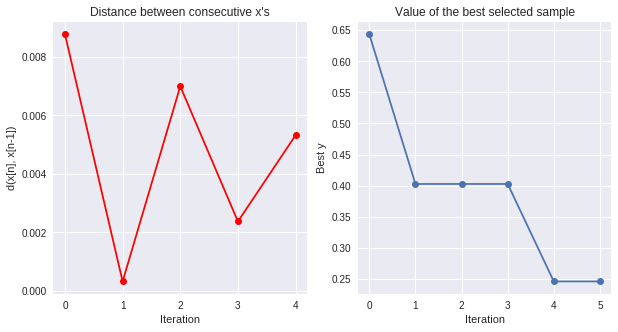

In [0]:
def train_Bayesian_Opt(params):
  
    ## Architecture
    inp = Input(shape = (max_seq,))

    x = Embedding(vocabulary_size+1, EMBEDDING_SIZE, weights = [embedding_matrix], trainable = True)(inp)
    x = SpatialDropout1D(0.5)(x)
    x = Bidirectional(LSTM(128, return_sequences = True))(x)
    x = Conv1D(64, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    x = Dense(10, activation = "relu")(x)

    a = Dense(1, activation = "sigmoid")(x)
    model_a = Model(inputs = inp, outputs = a)
    
    model_a.compile( loss = "binary_crossentropy", optimizer = Adam(lr = params[0,0], decay = params[0,1]), metrics = ["accuracy"])
    model_a.fit(np.array(X_train_a), y_train_a, validation_data=(X_test_a,y_test_a), epochs = 5)
    y_pred_a = model_a.predict(X_test_a)
    y_pred_a = y_pred_a>0.5
    
    
    
    
    ##Check the accuracy after every iteration of Bayesian Optimisation
    return f1_score(y_test_a, y_pred_a, average = "macro")
  

### For GPyOpt implementation details see: https://github.com/SheffieldML/GPyOpt/
domain = [{'name': 'lr',  'type': 'continuous',  'domain': (0.0005,0.01)}, {'name': 'w_decay',  'type': 'continuous',  'domain': (0, 0.000001)}]
opt = GPyOpt.methods.BayesianOptimization(f = train_Bayesian_Opt, domain = domain, acquisition_type ='LCB', acquisition_weight = 0.5)
opt.run_optimization(max_iter=10)
opt.plot_convergence()

